In [1]:
import openpyxl
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets.samples_generator import make_blobs

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Acquire Data
I had to do it a special way since it us a a .xlsx

In [2]:
wb = openpyxl.load_workbook("vgsales.csv.xlsx")
ws = wb.active

df = pd.DataFrame(list(ws.iter_rows(values_only=True)))

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33


# Prepare Data

In [4]:
# Set the column names 
    # had to do this because column names became first row
df.columns = df.iloc[0]

In [5]:
# set the index of the dataframe
df = df.set_index('Rank')

In [6]:
# drop the row with column names
df = df.drop('Rank', axis=0)

In [7]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33
5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1,31.37


In [8]:
df.Year.value_counts()

2009    1431
2008    1428
2010    1259
2007    1202
2011    1139
2006    1008
2005     941
2002     829
2003     775
2004     763
2012     657
2015     614
2014     582
2013     546
2001     482
1998     379
2000     349
2016     344
1999     338
1997     289
N/A      271
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1985      14
1984      14
1980       9
2017       3
2020       1
Name: Year, dtype: int64

In [9]:
df.isnull().sum()

0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [10]:
df.shape

(16598, 10)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16598 entries, 1 to 16600
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          16598 non-null  object
 1   Platform      16598 non-null  object
 2   Year          16598 non-null  object
 3   Genre         16598 non-null  object
 4   Publisher     16598 non-null  object
 5   NA_Sales      16598 non-null  object
 6   EU_Sales      16598 non-null  object
 7   JP_Sales      16598 non-null  object
 8   Other_Sales   16598 non-null  object
 9   Global_Sales  16598 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


In [12]:
df.describe()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598,16598,16598,16598,16598,16598.0,16598.0,16598.0,16598.0,16598.00
unique,11493,31,40,12,579,409.0,305.0,244.0,157.0,623.00
top,Need for Speed: Most Wanted,DS,2009,Action,Electronic Arts,0.0,0.0,0.0,0.0,0.02
freq,12,2163,1431,3316,1351,4499.0,5730.0,10455.0,6477.0,1071.00


In [13]:
df = df[~df['Year'].isin(['N/A'])]

In [14]:
df['Year'] = df['Year'].astype(int)
df['Global_Sales'] = df['Global_Sales'].astype(float)

In [15]:
df = df.drop(['NA_Sales', 'EU_Sales', 
             'JP_Sales', 'Other_Sales', 'Name'], axis=1)
# dropping these because they feed right into our target and Name is not needed

In [16]:
df.Year.max()

2020

In [17]:
df['years_binned'] = pd.cut(df.Year, 
                            bins = [1980,1985,1990,1995,2000,2005,2010,2015,2020],
                            labels = ['80-85', '85-90', '90-95', "95-00's", 
                                      "00's-05", '05-10', '10-15', '15-20'])

In [18]:
df.head()

,Platform,Year,Genre,Publisher,Global_Sales,years_binned
Rank,,,,,,
1,Wii,2006,Sports,Nintendo,82.74,05-10
2,NES,1985,Platform,Nintendo,40.24,80-85
3,Wii,2008,Racing,Nintendo,35.82,05-10
4,Wii,2009,Sports,Nintendo,33.00,05-10
5,GB,1996,Role-Playing,Nintendo,31.37,95-00's


In [19]:
df.Global_Sales.max()

82.74

# Lets see the distribution

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Global_Sales', ylabel='Density'>

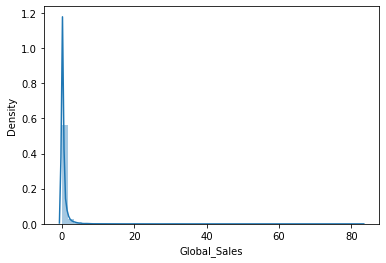

In [20]:
sns.distplot(df['Global_Sales'])

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year', ylabel='Density'>

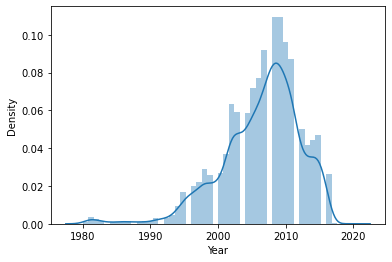

In [21]:
sns.distplot(df['Year'])

Takeaways:
- There was a HUGE spike in sales in the 2000's and continued to grow until there was a steady decline starting near 2010.

df.Platform.value_counts()

In [22]:
# Sony
df['Platform'] = df.Platform.replace('PS2','Playstation')
df['Platform'] = df.Platform.replace('PS3','Playstation')
df['Platform'] = df.Platform.replace('PSP','Playstation')
df['Platform'] = df.Platform.replace('PS','Playstation')
df['Platform'] = df.Platform.replace('PS4','Playstation')
# Xbox
df['Platform'] = df.Platform.replace('X360','Xbox')
df['Platform'] = df.Platform.replace('XB','Xbox')
df['Platform'] = df.Platform.replace('XOne','Xbox')
# Nintendo
df['Platform'] = df.Platform.replace('DS','Nintendo')
df['Platform'] = df.Platform.replace('Wii','Nintendo')
df['Platform'] = df.Platform.replace('GB','Nintendo')
df['Platform'] = df.Platform.replace('GC','Nintendo')
df['Platform'] = df.Platform.replace('3DS','Nintendo')
df['Platform'] = df.Platform.replace('SNES','Nintendo')
df['Platform'] = df.Platform.replace('WiiU','Nintendo')
df['Platform'] = df.Platform.replace('NES','Nintendo')
df['Platform'] = df.Platform.replace('Gameboy','Nintendo')
df['Platform'] = df.Platform.replace('N64','Nintendo')
df['Platform'] = df.Platform.replace('SCD','Nintendo')
df['Platform'] = df.Platform.replace('GBA','Nintendo')

# Computer
df['Platform'] = df.Platform.replace('PC','Computer')
df['Platform'] = df.Platform.replace('PSV','Computer')

# Sega
df['Platform'] = df.Platform.replace('SAT','Sega')
df['Platform'] = df.Platform.replace('DC','Sega')
df['Platform'] = df.Platform.replace('GEN','Sega')
df['Platform'] = df.Platform.replace('GG','Sega')

# Other
df['Platform'] = df.Platform.replace(2600,'Other')
df['Platform'] = df.Platform.replace('NG','Other')
df['Platform'] = df.Platform.replace('WS','Other')
df['Platform'] = df.Platform.replace('3DO','Other')
df['Platform'] = df.Platform.replace('TG16','Other')
df['Platform'] = df.Platform.replace('PCFX','Other')

In [23]:
df.Platform.value_counts()

Nintendo       6175
Playstation    6153
Xbox           2251
Computer       1355
Sega            253
Other           140
Name: Platform, dtype: int64

In [24]:
# create dummy variables and add them to the df
dummy_df =  pd.get_dummies(df['Platform'])
dummy_df.columns = ['Nintendo', 'Playstation', 'Xbox', 'Computer', 
                    'Sega', 'Other']
df = pd.concat([df, dummy_df], axis=1)

In [25]:
df.head()

,Platform,Year,Genre,Publisher,Global_Sales,years_binned,Nintendo,Playstation,Xbox,Computer,Sega,Other
Rank,,,,,,,,,,,,
1,Nintendo,2006,Sports,Nintendo,82.74,05-10,0,1,0,0,0,0
2,Nintendo,1985,Platform,Nintendo,40.24,80-85,0,1,0,0,0,0
3,Nintendo,2008,Racing,Nintendo,35.82,05-10,0,1,0,0,0,0
4,Nintendo,2009,Sports,Nintendo,33.00,05-10,0,1,0,0,0,0
5,Nintendo,1996,Role-Playing,Nintendo,31.37,95-00's,0,1,0,0,0,0


In [26]:
df.Genre.value_counts()

Action          3253
Sports          2304
Misc            1710
Role-Playing    1471
Shooter         1282
Adventure       1276
Racing          1226
Platform         876
Simulation       851
Fighting         836
Strategy         671
Puzzle           571
Name: Genre, dtype: int64

In [27]:
df['Genre'] = df.Genre.replace('Puzzle','Strategy')
df['Genre'] = df.Genre.replace('Action','Action-Adventure')
df['Genre'] = df.Genre.replace('Adventure','Action-Adventure')
df['Genre'] = df.Genre.replace('Fighting','Simulation')
df['Genre'] = df.Genre.replace('Racing','Simulation')

In [28]:
df.Genre.value_counts()

Action-Adventure    4529
Simulation          2913
Sports              2304
Misc                1710
Role-Playing        1471
Shooter             1282
Strategy            1242
Platform             876
Name: Genre, dtype: int64

In [29]:
# create dummy variables and add them to the df
dummy_df =  pd.get_dummies(df['Genre'])
dummy_df.columns = ['Action-Adventure', 'Simulation', 'Sports', 
                    'Misc', 'Role-Playing', 'Shooter', 
                    'Strategy', 'Platform']
df = pd.concat([df, dummy_df], axis=1)

In [30]:
df.head()

,Platform,Year,Genre,Publisher,Global_Sales,years_binned,Nintendo,Playstation,Xbox,Computer,Sega,Other,Action-Adventure,Simulation,Sports,Misc,Role-Playing,Shooter,Strategy,Platform
Rank,,,,,,,,,,,,,,,,,,,,
1,Nintendo,2006,Sports,Nintendo,82.74,05-10,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,Nintendo,1985,Platform,Nintendo,40.24,80-85,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,Nintendo,2008,Simulation,Nintendo,35.82,05-10,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,Nintendo,2009,Sports,Nintendo,33.00,05-10,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5,Nintendo,1996,Role-Playing,Nintendo,31.37,95-00's,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [31]:
#drop features
df = df.drop(['Publisher', 'Platform', 'Genre', 'Year'], axis=1)

In [32]:
df.head()

,Global_Sales,years_binned,Nintendo,Playstation,Xbox,Computer,Sega,Other,Action-Adventure,Simulation,Sports,Misc,Role-Playing,Shooter,Strategy
Rank,,,,,,,,,,,,,,,
1,82.74,05-10,0,1,0,0,0,0,0,0,0,0,0,0,1
2,40.24,80-85,0,1,0,0,0,0,0,0,1,0,0,0,0
3,35.82,05-10,0,1,0,0,0,0,0,0,0,0,0,1,0
4,33.00,05-10,0,1,0,0,0,0,0,0,0,0,0,0,1
5,31.37,95-00's,0,1,0,0,0,0,0,0,0,1,0,0,0


train_validate, test = train_test_split(df, test_size=.2, random_state=1234)
train, validate = train_test_split(train_validate, test_size=.3, 
                                       random_state=1234)

X_train = train.drop(columns = ['Global_Sales'])
y_train = pd.DataFrame(train.Global_Sales)
X_validate = validate.drop(columns=['Global_Sales'])
y_validate = pd.DataFrame(validate.Global_Sales)
X_test = test.drop(columns=['Global_Sales'])
y_test = pd.DataFrame(test.Global_Sales)

# Attempt at clustering